# Overfitting & Underfitting

### Import & Load

In [4]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [5]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"  # mkdtemp를 이용해 임시 폴더 생성
shutil.rmtree(logdir, ignore_errors=True) # shutil.rmtree를 이용해 하위 디렉토리와 파일 삭제

In [6]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz') # data load : 해당 경로에 파일 다운로드

2816417792/2816407858 [==============================] - 837s 0us/step


In [20]:
gz  # 28개의 feature와 이진 클래스레이블이 포함된 예제파일

'C:\\Users\\user\\.keras\\datasets\\HIGGS.csv.gz'

In [7]:
FEATURES = 28

In [8]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")  
# CSV Dataset 인터페이스 제공
# 중간 압축 해제 단계 없이 파일에서 직접 csv 레코드 읽기 가능
# 각 파일에대한 스칼라 목록 반환

In [9]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

# 스칼라 항목을 features_vecto, label 쌍으로 다시 압축

In [10]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()
# 10000개의 배치를 취하고 각 배치에 pack_row 함수 적용 -> 개별 레코드로 분할하는 새로운 tf.data.Dataset

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


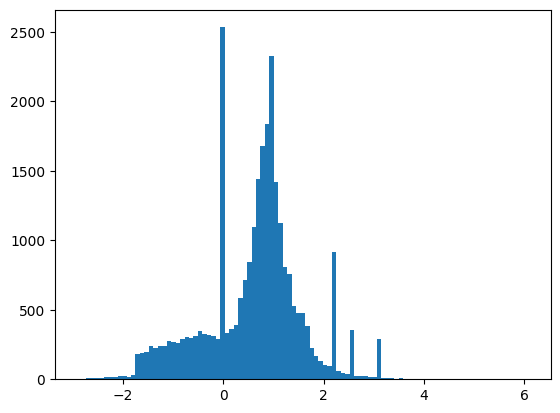

In [11]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [12]:
N_VALIDATION = int(1e3)  # 처음 1000개 샘플만 검증에 사용
N_TRAIN = int(1e4)  # 훈련 데이터 10000
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [13]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

# cache를 통해 각 epoch에서 파일 데이터를 다시 읽을 필요가 없게 함 

In [14]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [15]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)
# 훈련에 적합한 크기의 배치 생성
# 단일 원소를 batch_size만큼 쌓음
# repeat 사용 시 input을 인자만큼 무한 반복
# repeat 후 batch를 적용해 에폭간의 경계를 없앰

## Overfitting

In [16]:
######### 학습률 조정
# InverseTimeDecay -> 초기 학습률이 주어지면 optimizer 단계에 역 감쇠 함수 적용
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)
# 계산 식 : initial_learning_rate / (1+decay_rate*step / decay_step)


def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

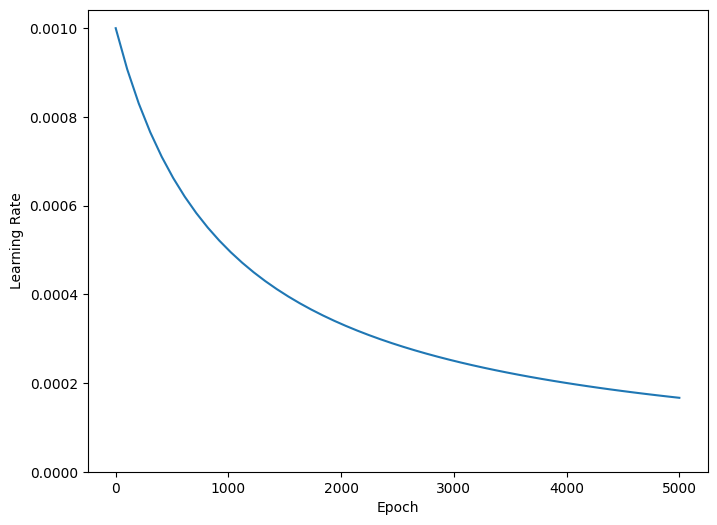

In [21]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [22]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),  # 훈련에 대한 tensorboard log 생성
  ]

In [23]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()  # optimizer : adam
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

##### Tiny Model

In [24]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

# ELU : exponential linear unit
# ReLU와 유사함, 지수함수를 이용해 입력이 0이하일 경우 부드럽게 깍음, 미분 함수가 끊어지지 않고 이어진 형태

In [25]:
size_histories = {}

In [26]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4642,  binary_crossentropy:0.7976,  loss:0.7976,  val_accuracy:0.4470,  val_binary_crossentropy:0.7807,  val_loss:0.7807,  
....................................................................................................
Epoch: 100, accuracy:0.5821,  binary_crossentropy:0.6326,  loss:0.6326,  val_accuracy:0.5710,  val_binary_crossentropy:0.6303,  val_loss:0.6303,  
............................................................

(0.5, 0.7)

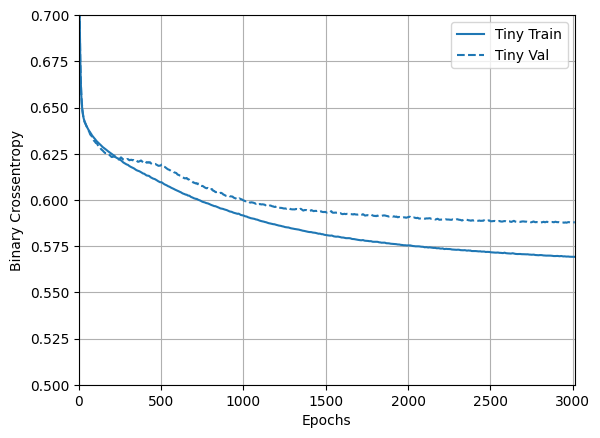

In [27]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

##### Tiny Model2 (Small)

In [28]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

# 이전 모델에서 Dense 1개 추가

In [29]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4750,  binary_crossentropy:0.7263,  loss:0.7263,  val_accuracy:0.4680,  val_binary_crossentropy:0.7037,  val_loss:0.7037,  
....................................................................................................
Epoch: 100, accuracy:0.6227,  binary_crossentropy:0.6165,  loss:0.6165,  

##### Medium Model

In [45]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [31]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                1856      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4937,  binary_crossentropy:0.6899,  loss:0.6899,  val_accuracy:0.5180,  val_binary_crossentropy:0.6775,  val_loss:0.6775,  
....................................

##### Large Model

In [32]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [33]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               14848     
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5058,  binary_crossentropy

Text(0.5, 0, 'Epochs [Log Scale]')

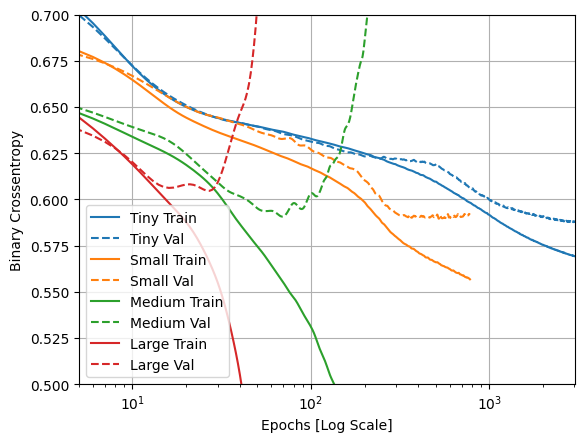

In [34]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

- 실선 : train loss, 점선 : val loss
- Tiny 모델의 경우 과대 적합을 피한듯 보이고, 더 큰 모델일 수록 더 빠르게 과대적합

## Overfitting 방지 전략

##### Tiny 모델의 훈련 로그를 복사해 비교 기준으로 삼음

In [35]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

WindowsPath('C:/Users/user/AppData/Local/Temp/tmpo94ct7fh/tensorboard_logs/regularizers/Tiny')

In [36]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

##### 가중치 규제  -  L2
- 가중치가 작은 값만 사용, 가중치 값의 분포를 정규화시킴 -> 네트워크 복잡성에 제약을 가함
    => 가중치 정규화
- L1 규제 : 가중치 절댓값에 비례하는 비용 추가
- L2 규제 : 가중치 제곱에 비례하는 비용 추가, 가중치 감쇠

In [37]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 512)               14848     
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dense_18 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5121,  binary_crossentropy

(0.5, 0.7)

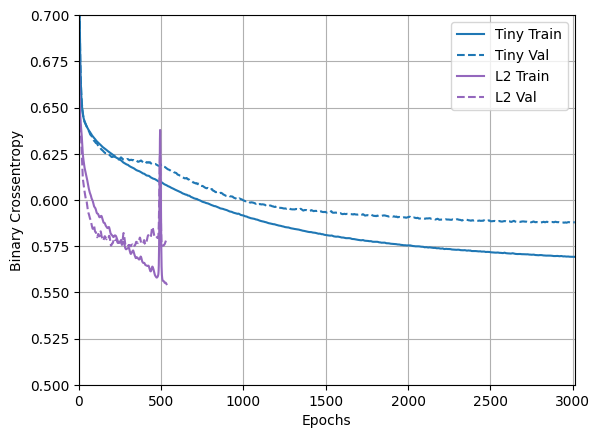

In [38]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [39]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

##### Dropout
- 각 노드는 자체적으로 유용한 요소를 출력해야함

In [40]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 512)               14848     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 512)              

(0.5, 0.7)

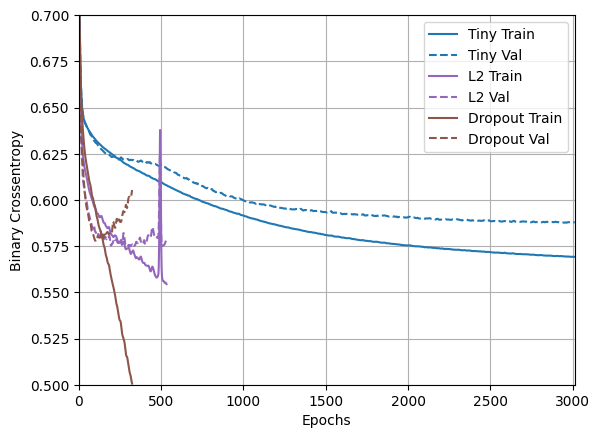

In [41]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

##### L2 + Dropout

In [42]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               14848     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 512)              

(0.5, 0.7)

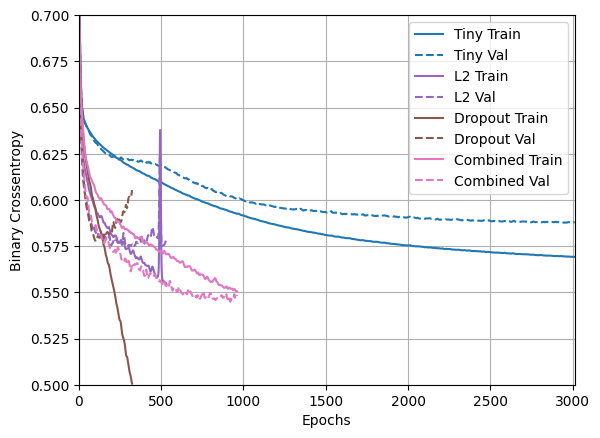

In [43]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

## Conclusion
- Overfitting 방지
    - 더 많은 훈련 데이터를 가짐
    - 네트워크 용량을 줄임
    - 가중치 정규화 추가
    - 드롭아웃 추가
    - 데이터 증강
    - 배치 정규화 ( tf.keras.BatchNormarlization )